In [47]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.random.set_seed(0)

In [48]:
def NN_plot(nn):
    nn.compile(loss = 'mse')
    xgrid = np.linspace(-10,10,201)
    y = nn.predict(xgrid)
    plt.plot(xgrid,y)
    plt.grid()
    plt.show()

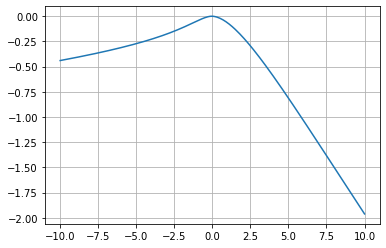

In [49]:
# Independent Control Neural Network: u(x)
inputs = keras.Input(shape=(1))
l1 = layers.Dense(8, activation = 'elu')
l2= layers.Dense(8, activation = 'elu')
l3= layers.Dense(1, activation = 'linear')
outputs = l1(inputs)
outputs = l2(outputs)
outputs = l3(outputs)
# outputs = -inputs
control_NN = keras.Model(inputs=inputs, outputs=outputs, name = 'control_NN')
# control_NN.summary()
NN_plot(control_NN)

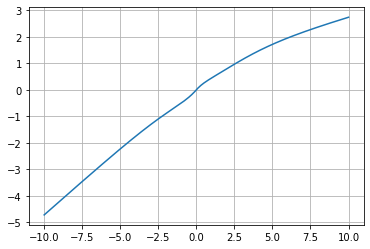

In [51]:
# Value Neural Network: V(x)
inputs = keras.Input(shape=(1))
l1 = layers.Dense(8, activation = 'elu')
l2= layers.Dense(8, activation = 'elu')
l3= layers.Dense(1, activation = 'linear')
outputs = l1(inputs)
outputs = l2(outputs)
outputs = l3(outputs)
# outputs = inputs**2
value_NN = keras.Model(inputs=inputs, outputs=outputs, name = 'value_NN')
# value_NN.summary()
NN_plot(value_NN)

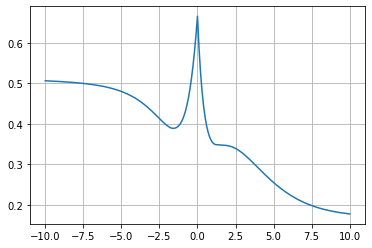

In [52]:
# derivative of Value Neural Network: dV(x)/dx
inputs = keras.Input(shape=(1))
with tf.GradientTape() as t:
    t.watch(inputs)
    outputs0 = value_NN(inputs)
# dy = 2x
outputs = t.gradient(outputs0, inputs)
d_value_NN = keras.Model(inputs=inputs, outputs=outputs, name = 'd_value_NN')
# d_value_NN.summary()
NN_plot(d_value_NN)

In [53]:
# optimal value: rho
inputs = keras.Input(shape=(1))
l= layers.Dense(1, activation = 'linear')
outputs = l(inputs)
rho_NN = keras.Model(inputs=inputs, outputs=outputs, name = 'rho')
# rho_NN.summary()
rho_NN.predict(np.zeros(1))[0,0]

0.0

In [54]:
# Global Parameter
steps = 100
dt = 0.01
sqrtdt = np.sqrt(dt)
T = steps * dt
M = 1000

\begin{equation*}
     \left\{
     \begin{aligned}
          L_{n}(\theta) &= \mathbb{E}\Bigg[\Bigg( V^{\theta}(X_{t_{n+1}}) + \int_{t_{n}}^{t_{n+1}} \Big[c(X_{t},u^{\theta}(X_{t}))-\rho
          ^{\theta}\Big]dt - \int_{t_{n}}^{t_{n+1}}\frac{dV^{\theta}}{dx}(X_{t})\sigma(X_{t})dW_{t} - V^{\theta}(X_{t_{n}}) \Bigg)^2\Bigg] \\
          \theta_{n}^{*} &= \arg\min_{\theta \in \Theta}L_{n}(\theta)
     \end{aligned}
     \right.
\end{equation*}


\begin{equation*}
     \left\{
     \begin{aligned}
          L_{n}(\theta) &= \mathbb{E}\Bigg[\Bigg( V^{\theta}(X_{t_{n+1}}) + \int_{t_{n}}^{t_{n+1}} \Big[c(X_{t},u^{\theta}(X_{t}))-\rho
          ^{\theta}\Big]dt - V^{\theta}(X_{t_{n}}) \Bigg)^2\Bigg] \\
          \theta_{n}^{*} &= \arg\min_{\theta \in \Theta}L_{n}(\theta)
     \end{aligned}
     \right.
\end{equation*}


In [55]:
input_x = keras.Input(shape=(1))
inputs = [input_x]
X_start = input_x
X_now = X_start
loss = tf.zeros_like(X_now)
bsde = tf.zeros_like(X_now)
loss_output = [loss]
rho = rho_NN(tf.zeros_like(X_now))


for i in range(steps):
    input_dW = keras.Input(shape=(1))
    inputs = inputs + [input_dW]
    u_now = control_NN(X_now)
#     u_now = -0.5*d_value_NN(X_now)
    X_next  = X_now + input_dW + u_now * dt
    loss_tmp = (tf.math.square(X_now) + tf.math.square(u_now))*dt
    loss_output = loss_output + [loss_tmp]
    loss = loss + loss_tmp
    bsde_tmp = -2*tf.multiply(u_now,input_dW)
    bsde = bsde + bsde_tmp
    X_now = X_next
    
outputs = loss - bsde - rho*T + value_NN(X_now) - value_NN(X_start)

control_main = keras.Model(inputs=inputs, outputs = outputs, name = 'control_main')
control_terminal = keras.Model(inputs=inputs, outputs = X_now, name = 'control_terminal')
control_loss = keras.Model(inputs=inputs, outputs = loss_output, name = 'control_loss')
# control_loss.summary()

# control_terminal.compile(loss = square_loss)
# control_loss.compile(loss = square_loss)

In [56]:
def trainning_data(seed,X0,samplesM):
    np.random.seed(seed)
    x = [X0]
    for i in range(steps):
        x = x + [np.random.normal(0,sqrtdt,size = (samplesM,1))]
    y = np.zeros(shape = (samplesM,1))
    return x, y

In [57]:
np.random.seed(0)
X0 = np.random.normal(0,np.sqrt(1/2),size = (M,1))
# X0 = np.ones(shape = (M,1))
# X0 = np.zeros(shape = (M,1))
x_train, y_train = trainning_data(0,X0,M)
x_valid, y_valid = trainning_data(1,X0,M)
# x_test, y_test = trainning_data(2,X0,M)

In [58]:
def square_loss(target_y, predicted_y):
    return tf.reduce_mean(tf.math.square(predicted_y - target_y))
custom_optimizer = keras.optimizers.Adam(learning_rate = 0.01)

control_main.compile(loss = square_loss , optimizer = custom_optimizer)
control_main.evaluate(x_train,y_train)
control_main.fit(x_train,y_train,epochs = 50,validation_data = (x_valid,y_valid), verbose = 1)

1000/1000 [==============================] - 9s 9ms/sample - loss: 3.0482
Train on 1000 samples, validate on 1000 samples
Epoch 1/50
1000/1000 [==============================] - 43s 43ms/sample - loss: 1.2856 - val_loss: 0.8198
Epoch 2/50
1000/1000 [==============================] - 5s 5ms/sample - loss: 0.6942 - val_loss: 0.4019
Epoch 3/50
1000/1000 [==============================] - 5s 5ms/sample - loss: 0.2854 - val_loss: 0.1376
Epoch 4/50
1000/1000 [==============================] - 5s 5ms/sample - loss: 0.1035 - val_loss: 0.0624
Epoch 5/50
1000/1000 [==============================] - 5s 5ms/sample - loss: 0.0631 - val_loss: 0.0395
Epoch 6/50
1000/1000 [==============================] - 5s 5ms/sample - loss: 0.0424 - val_loss: 0.0324
Epoch 7/50
1000/1000 [==============================] - 5s 5ms/sample - loss: 0.0368 - val_loss: 0.0305
Epoch 8/50
1000/1000 [==============================] - 5s 5ms/sample - loss: 0.0340 - val_loss: 0.0325
Epoch 9/50
1000/1000 [======================

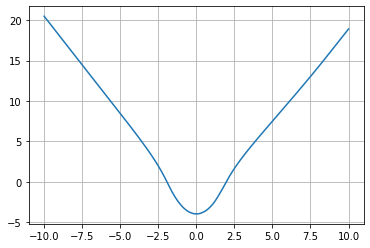

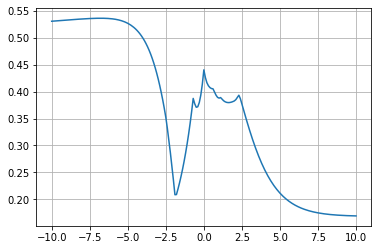

1.0011487

In [59]:
NN_plot(value_NN)
NN_plot(d_value_NN)
rho_NN.predict(np.zeros(1))[0,0]